# Teacher Forcing in RNNs

**Roberto Fierimonte** - 19/02/2018

---

In [386]:
import scipy
import datetime
import functools
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline 

tfd = tf.contrib.distributions
tfb = tf.contrib.bayesflow

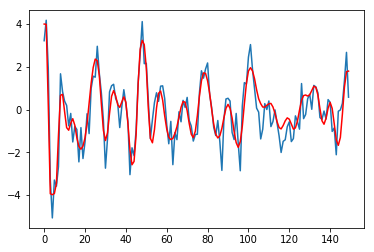

In [397]:
np.random.seed(2)
n_hidden = 50; seq_length = 300;
h = np.zeros((seq_length + 1, n_hidden)); h[0] = np.random.rand(1, n_hidden)
y = np.zeros((seq_length + 1, 1)); y[0] = [0]
sigma_c = 0.7
sigma_b = 0.01

A = 0.05 * np.random.randn(n_hidden, n_hidden)
R = scipy.linalg.expm(A - A.T)
B = -0.001 * np.random.rand(1, n_hidden)
b = np.random.rand(n_hidden, 1)

for i in range(1, seq_length + 1):
    h[i] = np.tanh(np.dot(h[i-1], R) + np.dot(y[i-1], B))
    y[i] = 4 * np.tanh(np.dot(h[i], b)) + sigma_b * np.random.randn(1)

y_tilde = (y[1:] + sigma_c * np.random.randn(seq_length, 20)).T
plt.plot(y_tilde[0, :150]);
ts = y_tilde[0]
plt.plot(y[1:151], 'r')

In [398]:
def doublewrap(function):
    """
    A decorator decorator, allowing to use the decorator to be used without
    parentheses if not arguments are provided. All arguments must be optional.
    """
    @functools.wraps(function)
    def decorator(*args, **kwargs):
        if len(args) == 1 and len(kwargs) == 0 and callable(args[0]):
            return function(args[0])
        else:
            return lambda wrapee: function(wrapee, *args, **kwargs)
    return decorator


@doublewrap
def define_scope(function, scope=None, *args, **kwargs):
    """
    A decorator for functions that define TensorFlow operations. The wrapped
    function will only be executed once. Subsequent calls to it will directly
    return the result so that operations are added to the graph only once.
    The operations added by the function live within a tf.variable_scope(). If
    this decorator is used with arguments, they will be forwarded to the
    variable scope. The scope name defaults to the name of the wrapped
    function.
    """
    attribute = '_cache_' + function.__name__
    name = scope or function.__name__
    @property
    @functools.wraps(function)
    def decorator(self):
        if not hasattr(self, attribute):
            with tf.variable_scope(name, *args, **kwargs):
                setattr(self, attribute, function(self))
        return getattr(self, attribute)
    return decorator

# Baseline Model

In [399]:
class LinearCell(tf.contrib.rnn.RNNCell):
    """
    """
    def __init__(self, output_size, state_size, reuse=None):
        super(LinearCell, self).__init__(_reuse=reuse)
        self._output_size = output_size
        self._state_size = state_size
    
    @property
    def state_size(self):
        return self._state_size
    
    @property
    def output_size(self):
        return self._output_size
    
    def call(self, inputs, state):
        state = tf.layers.dense(inputs, self._state_size) + tf.layers.dense(state, self._state_size)
        out = tf.layers.dense(state, self._output_size)
        return out, state

class SimpleSamplingCell(tf.contrib.rnn.RNNCell):
    """
    """
    def __init__(self, cell, output_size, layer, reuse=None):
        super(SimpleSamplingCell, self).__init__(_reuse=reuse)
        self._cell = cell
        self._output_size = output_size
        self._layer = layer

    @property
    def state_size(self):
        return (self._cell.state_size, self._output_size)

    @property
    def output_size(self):
        return (self._output_size)
    
    def call(self, inputs, state_and_sample):
        del inputs  # Unused.
        (state, sample) = state_and_sample
        out, state = self._cell(sample, state)
        sample = self._layer(out)
        return sample, (state, sample)
    
class BaselineModel(object):
    """
    """
    def __init__(self, cell_type='GRU', n_hidden=100):
        self._n_hidden = n_hidden
        self._cell_type = cell_type
        if cell_type == 'Linear':
            self._cell = LinearCell(1, self._n_hidden)
            self._sampling_cell = self._cell
        else:
            self._layer = tf.layers.Dense(1)
            if cell_type == 'GRU':
                self._cell = tf.contrib.rnn.GRUBlockCell(self._n_hidden)
            elif cell_type == 'LSTM':
                self._cell = tf.contrib.rnn.LSTMBlockCell(self._n_hidden)
            elif cell_type == 'RNN':
                self._cell = tf.contrib.rnn.BasicRNNCell(self._n_hidden)
            self._sampling_cell = SimpleSamplingCell(self._cell, 1, self._layer)

    def compute_forward(self, data):
        (out, hidden) = tf.nn.dynamic_rnn(self._cell, inputs=data, dtype=tf.float32)
        if self._cell_type != 'Linear':
            out = self._layer(out)
        return out, hidden    
    
    def pred_forward(self, data, last_training_point, last_hidden):
        inputs = tf.concat([last_training_point[:, None], data], 1)        
        (out, _) = tf.nn.dynamic_rnn(self._cell, inputs=inputs, initial_state=last_hidden, dtype=tf.float32)
        if self._cell_type != 'Linear':
            out = self._layer(out)
        return out
    
    def pred_forward_autoregressive(self, last_training_point, last_hidden, future=500):
        sample = last_training_point
        hidden = last_hidden
        samples = []
        
        for _ in range(future):
            (sample, hidden) = self._cell(sample, hidden)
            if self._cell_type != 'Linear':
                sample = self._layer(sample)
            samples.append(sample)
            
        return tf.transpose(tf.stack(samples, 0), [1,0,2])

In [400]:
tf.reset_default_graph()

seq_length = 150; cell_type = 'Linear'; n_hidden = 10
x_ = tf.placeholder(tf.float32, [None, None, 1])
x_test = tf.placeholder(tf.float32, [None, None, 1])

with tf.variable_scope(cell_type + '_' + str(n_hidden), reuse=tf.AUTO_REUSE) as scope:
    model = BaselineModel(cell_type, n_hidden)
    res, hidden = model.compute_forward(x_[:, :-1])
    loss = tf.reduce_mean(tf.reduce_sum(tf.square(res[..., 0] - x_[:, 1:, 0]), 1))/2
    optimise = tf.train.AdamOptimizer(0.001).minimize(loss)
    
    pred_tf = model.pred_forward(x_test, x_[:, -1], hidden)
    pred_ar_tf = model.pred_forward_autoregressive(x_[:, -1], hidden, future=100)

config = tf.ConfigProto(allow_soft_placement=True)
sess = tf.InteractiveSession(config=config) 
sess.run(tf.global_variables_initializer())

saver = tf.train.Saver()
errors_baseline = []; preds_baseline = []; preds_baseline_ar = []; errors_test_baseline = []

timestamp = datetime.datetime.strftime(datetime.datetime.now(), "%Y-%m-%d_%H:%M")

for i in range(10001):
    batch = ts[None, :seq_length+1]
#     batch = np.stack([ts[i:i+seq_length] for i in np.random.randint(0, 150-seq_length, 10)])    
    error = sess.run(loss, {x_: batch[..., None]})
    sess.run(optimise, {x_: batch[..., None]})
    errors_baseline.append(error)
    
    if i % 1000 == 0:
        test_batch = ts[seq_length+1:]
        test_error = sess.run(loss, {x_: test_batch[None, :, None]})
        errors_test_baseline.append(test_error)
        print('Iteration:', i, 'Training Error:', error, 'Test Error:', test_error)
        pred = sess.run(pred_tf, {x_: ts[None, :seq_length+1, None], x_test: ts[None, seq_length+1:, None]})
        pred_ar = sess.run(pred_ar_tf, {x_: ts[None, :seq_length, None]})
        preds_baseline.append(pred); preds_baseline_ar.append(pred_ar)
        
# save_path = saver.save(sess, "/mnt/workspace/baseline_{}_length_{}_iter_{}.ckpt".format(timestamp, seq_length, i))

Iteration: 0 Training Error: 627.6327 Test Error: 176.98245
Iteration: 1000 Training Error: 81.24565 Test Error: 67.66461
Iteration: 2000 Training Error: 79.94226 Test Error: 67.26721
Iteration: 3000 Training Error: 81.52586 Test Error: 68.82626
Iteration: 4000 Training Error: 79.92978 Test Error: 67.470985
Iteration: 5000 Training Error: 79.304344 Test Error: 67.277885
Iteration: 6000 Training Error: 76.194824 Test Error: 66.80928
Iteration: 7000 Training Error: 71.47736 Test Error: 71.878746
Iteration: 8000 Training Error: 66.90598 Test Error: 79.83891
Iteration: 9000 Training Error: 64.66897 Test Error: 82.55424
Iteration: 10000 Training Error: 59.528004 Test Error: 97.17132


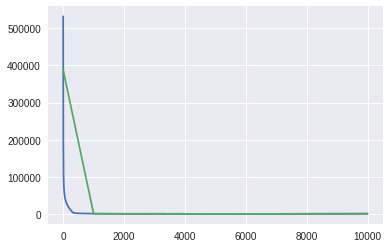

In [161]:
plt.plot(errors_baseline)
plt.plot(range(0, 10001, 1000), errors_test_baseline)

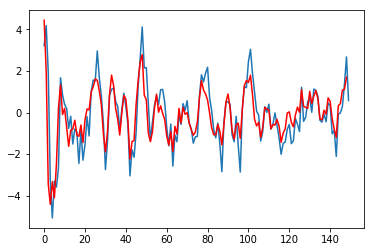

In [401]:
fit = sess.run(res, {x_: ts[None, :150, None]})
plt.plot(ts[None, :150].T)
plt.plot(fit[..., 0].T, 'r')

In [409]:
pred.shape

(1, 150, 1)

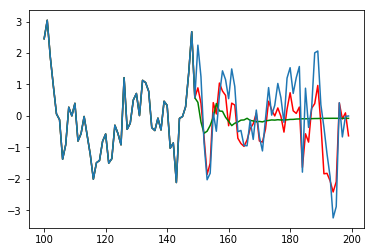

In [410]:
plt.plot(range(100, 200), np.concatenate([ts[None, 100:150, None], pred[:, :50]], 1)[0], 'r')
plt.plot(range(100, 200), np.concatenate([ts[None, 100:150, None], pred_ar[:, :50]], 1)[0], 'g-')
plt.plot(range(100, 200), ts[None, 100:200].T)

# Our Model

In [383]:
class RecognitionNetwork(object):
    
    def __init__(self, data, n_outputs=50, cell_type='GRU', n_hidden=100):
        self._data = data
        self._n_outputs = n_outputs
        self._n_hidden = n_hidden
        self._layer1 = tf.layers.Dense(self._n_outputs)
        self._layer2 = tf.layers.Dense(self._n_outputs, tf.nn.softplus)
        
        if cell_type == 'GRU':
            self._cell = tf.contrib.rnn.GRUBlockCell(self._n_hidden)
        elif cell_type == 'LSTM':
            self._cell = tf.contrib.rnn.LSTMBlockCell(self._n_hidden)
        elif cell_type == 'RNN':
            self._cell = tf.contrib.rnn.BasicRNNCell(self._n_hidden)
    
    @define_scope
    def make_post_z(self):        
        (out, _) = tf.nn.dynamic_rnn(self._cell, self._data, dtype=tf.float32)
        means = self._layer1(out[:, -1])
        stds = self._layer2(out[:, -1])
        return tfd.MultivariateNormalDiag(means, stds)

class GaussianCellFixedSigma(tf.contrib.rnn.RNNCell):
    """
    RNN cell that outputs mean and standard deviation at every step
    """

    def __init__(self, cell, event_size, batch_size, reuse=None):
        super(GaussianCellFixedSigma, self).__init__(_reuse=reuse)
        self._cell = cell
        self._event_size = event_size
        self._batch_size = batch_size
        self._std = tf.nn.softplus(tf.get_variable(shape=(1, event_size), name='cell_std',
                                                   initializer=tf.constant_initializer(1)))

    @property
    def state_size(self):
        return self._cell.state_size

    @property
    def output_size(self):
        return (self._event_size, self._event_size)

    def call(self, inputs, state):
        _, hidden = self._cell(inputs, state)
        mean = tf.layers.dense(hidden, self._event_size)
        return (mean, tf.tile(self._std, [self._batch_size, 1])), hidden

class SamplingCellWithInputs(tf.contrib.rnn.RNNCell):
    """
    RNN cell that produce a sequence in autoregressive mode by sampling at
    each step
    """

    def __init__(self, cell, output_size, n_samples=1, reuse=None):
        super(SamplingCellWithInputs, self).__init__(_reuse=reuse)
        self._cell = cell
        self._output_size = output_size
        self._n_samples = n_samples

    @property
    def state_size(self):
        return (self._cell.state_size, self._output_size)

    @property
    def output_size(self):
        return (self._output_size, self._output_size)

    def call(self, inputs , state_and_sample):
        (state, sample) = state_and_sample
        print(inputs.shape, sample.shape)
        sample = tf.concat([sample, inputs], 1)
        (mean, std), state = self._cell(sample, state)
        sample = tfd.Normal(mean, std).sample()
        return (mean, std), (state, sample)
    
class SamplingCell(tf.contrib.rnn.RNNCell):
    """
    RNN cell that produce a sequence in autoregressive mode by sampling at
    each step
    """

    def __init__(self, cell, output_size, n_samples=1, reuse=None):
        super(SamplingCell, self).__init__(_reuse=reuse)
        self._cell = cell
        self._output_size = output_size
        self._n_samples = n_samples

    @property
    def state_size(self):
        return (self._cell.state_size, self._output_size)

    @property
    def output_size(self):
        return (self._output_size, self._output_size)

    def call(self, _ , state_and_sample):
        (state, sample) = state_and_sample
        (mean, std), state = self._cell(sample, state)
        sample = tfd.Normal(mean, std).sample()
        return (mean, std), (state, sample)
    
class RobustARGenerator(object):
    """
    Model to test
    """
    def __init__(self, data, n_hidden=100, n_samples=200, seq_length=1000, batch_size=1, first_hidden=None):
        self._data = data
        self._n_hidden = n_hidden
        self._batch_size = batch_size
        self._n_samples = n_samples
        self._seq_length = seq_length
        if first_hidden is not None:
            self._z = first_hidden
        else:
            self._z = tf.zeros((self._batch_size * self._n_samples, self._n_hidden))
        
        self._optimiser = tf.train.AdamOptimizer(0.001)
        self._gen_stddev = tf.nn.softplus(tf.get_variable('generative_std', shape=(), 
                                           initializer=tf.constant_initializer(1)))
        self.make_posterior
#         self.make_marginal_posterior
        self.make_joint_posterior_entropy
        self.compute_elbo
        self.E_step
        self.M_step

    @define_scope
    def make_posterior(self):
        self._post_gru_cell = tf.contrib.rnn.GRUBlockCell(self._n_hidden)
        self._post_cell = GaussianCellFixedSigma(self._post_gru_cell, 1, self._batch_size)
        self._post_stddev = tf.squeeze(self._post_cell._std)
        self._post_sampling_cell = SamplingCellWithInputs(self._post_cell, 1)
        
        h0 = (tf.zeros((self._batch_size, self._n_hidden)), tf.zeros((self._batch_size, 1)))
        (means, stds), _ = tf.nn.dynamic_rnn(self._post_sampling_cell, inputs=self._data, initial_state=h0)
        return tfd.MultivariateNormalDiag(means[..., 0], scale_diag=stds[..., 0])
    
#     @define_scope
#     def make_posterior(self):
#         self._post_gru_cell = tf.contrib.rnn.GRUBlockCell(self._n_hidden)
#         self._post_cell = GaussianCellFixedSigma(self._post_gru_cell, 1, self._batch_size)
#         self._post_stddev = tf.squeeze(self._post_cell._std)
#         self._post_sampling_cell = SamplingCell(self._post_cell, 1)
        
#         fake_data = tf.zeros_like(self._data)
#         h0 = (tf.zeros((self._batch_size, self._n_hidden)), tf.zeros((self._batch_size, 1)))
#         (means, stds), _ = tf.nn.dynamic_rnn(self._post_sampling_cell, inputs=fake_data, initial_state=h0)
#         return tfd.MultivariateNormalDiag(means[..., 0], scale_diag=stds[..., 0])
    
    @define_scope
    def make_joint_posterior_entropy(self):
        post_means = tf.Print(self.make_posterior.mean()[None, ...], [tf.reduce_max(self.make_posterior.mean(), 1),
                                                                      tf.reduce_min(self.make_posterior.mean(), 1)])
        code = self.make_posterior.sample((n_samples))
        diffs = tf.Print(code - post_means, [tf.reduce_max(code, 1), tf.reduce_min(code, 1)])
        logdets = []
        for i in range(batch_size):
            cov = tf.matmul(tf.transpose(diffs[:, i, :]), diffs[:, i, :])/(self._n_samples - 1)
            logdet = tf.linalg.logdet(cov + 1e-5 * tf.eye(self._seq_length))
            logdets.append(logdet)
            
        return tf.stack(logdets, 0)
    
    @define_scope
    def make_marginal_posterior(self):
        sampling_cell = SamplingCell(
                    GaussianCellFixedSigma(self._post_gru_cell, 1, self._batch_size * self._n_samples), 1)
        outs = []; states = [];
        
        y0 = tf.zeros((self._batch_size * self._n_samples, 1))
        h0 = (tf.zeros((self._batch_size * self._n_samples, self._n_hidden)), 
              tf.zeros((self._batch_size * self._n_samples, 1)))  
        
        samples = []
        _, (state, sample) = sampling_cell(y0, h0) 
        sample = tf.reduce_mean(tf.reshape(sample, [self._n_samples, self._batch_size, 1]), 0, keepdims=True)
        sample = tf.reshape(tf.tile(sample, [self._n_samples, 1, 1]), [-1, 1])
                       
        print(state.shape, sample.shape)
        samples.append(sample)
        
        for time in range(self._seq_length - 1):
            
            _, (state, sample) = sampling_cell(y0, (state, sample))
            samples.append(sample)
        
        samples = tf.stack(samples, 1)
        print(samples.shape)
        raise Exception
        return (posterior_samples[:, -1, :], state)
    
    @define_scope
    def make_transitional(self):
        self._cell = tf.contrib.rnn.GRUBlockCell(self._n_hidden)
        self._trans_gaussian_cell = GaussianCellFixedSigma(self._cell, 1, batch_size * self._n_samples)        
        (m1, _), h1 = self._trans_gaussian_cell(tf.zeros((self._batch_size * self._n_samples, 1)), self._z)
        (means, _), _ = tf.nn.dynamic_rnn(self._trans_gaussian_cell, inputs=self._code[:, :-1], initial_state=h1)
        return tf.concat([m1[..., None], means], 1)
    
    @define_scope
    def compute_elbo(self):      
        posterior = self.make_posterior
        post_mean = posterior.mean()
        code = posterior.sample((self._n_samples))
        self._code = tf.reshape(code, [-1, self._seq_length])[..., None]
        
        entropy = tf.reduce_sum(self.make_joint_posterior_entropy)
        means = self.make_transitional
        exponent_trans = tf.square(self._code[..., 0] - means[..., 0])
        exponent_trans = tf.reshape(exponent_trans, [self._n_samples, self._batch_size, self._seq_length])
        
        kl = - entropy + tf.reduce_sum(tf.reduce_mean(exponent_trans, 0))/tf.square(self.trans_std)
        kl = kl + self._batch_size * self._seq_length * tf.log(tf.square(self.trans_std))
        
        exp1 = tf.square(code - self._data[None, :self._batch_size, ..., 0])
        exponent_gen = tf.reduce_sum(tf.reduce_mean(exp1, 0))/tf.square(self._gen_stddev)
        
        reconstruction = - exponent_gen - self._seq_length * self._batch_size * tf.log(tf.square(self._gen_stddev))
        
        return reconstruction - kl, kl, reconstruction, entropy
    
    @define_scope
    def E_step(self):
        post_var = [v for v in tf.trainable_variables() if v.name.startswith('make_posterior/')]
        return self._optimiser.minimize(-self.compute_elbo[0], var_list=post_var)
    
    @define_scope
    def M_step(self):
        non_post_var = [v for v in tf.trainable_variables() if not v.name.startswith('make_posterior/')]
        return self._optimiser.minimize(-self.compute_elbo[0], var_list=non_post_var)
    
    @define_scope
    def trans_std(self):
        return tf.reduce_mean(self._trans_gaussian_cell._std)
    
    @define_scope
    def gen_std(self):
        return self._gen_stddev

In [384]:
tf.reset_default_graph()

seq_length = 150; n_samples = 10; batch_size = 10;
# data = np.tile(y_tilde[:batch_size, :seq_length], (n_samples, 1))
x_ = tf.placeholder(tf.float32, [batch_size, seq_length, 1])

# rec_model = RecognitionNetwork(n_hidden)
# q_z = rec_model(x_)
# p_z = tfd.MultivariateNormalDiag(tf.zeros(n_hidden), tf.ones(n_hidden))
# z_post = q_z.sample()

gen_model = RobustARGenerator(x_, n_hidden=3, n_samples=n_samples, seq_length=seq_length, batch_size=batch_size)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

elbos = []; kls = []; llks = []; test_elbos = []; preds = []; preds_greedy = []
means = []; stds = []; gen_stddevs = []; post_stddevs = []; post_samples = []; post_means = []

for i in range(20001):
    batch = y_tilde[:batch_size, :seq_length]
    
    if i % 10 == 0:
        elbo, kl, llk, entropy = sess.run(gen_model.compute_elbo, {x_: batch[..., None]})
        elbos.append(elbo); kls.append(kl); llks.append(llk)
        post_means.append(sess.run(gen_model.make_posterior.mean(), {x_: batch[..., None]})) 
        post_stddevs.append(sess.run(gen_model._post_stddev))
        m = sess.run(gen_model.make_transitional, {x_: batch[..., None]})
        s = sess.run(gen_model.trans_std, {x_: batch[..., None]})
        means.append(m); stds.append(s); gen_stddevs.append(sess.run(gen_model.gen_std, {x_: batch[..., None]}))
        latents = sess.run(gen_model.make_posterior.sample(n_samples), {x_: batch[..., None]})
        post_samples.append(latents)
        print('Iteration:', i, 'ELBO:', elbo, 'KL:', kl, 'Reconstruction:', llk, 'Entropy:', entropy)
    
    sess.run(gen_model.E_step, {x_: batch[..., None]})
    sess.run(gen_model.M_step, {x_: batch[..., None]})

(10, 1) (10, 1)
Iteration: 0 ELBO: -22807.611 KL: 18394.375 Reconstruction: -4413.2363 Entropy: -15790.258


KeyboardInterrupt: 

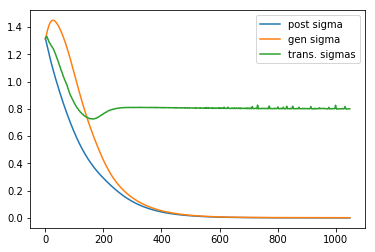

In [379]:
# p is RNN + linear proj., sigma_c is unknown, q is an RNN on the observed values + linear proj. (10 sample)
plt.plot(np.squeeze(np.array(post_stddevs)), label='post sigma')
plt.plot(gen_stddevs, label='gen sigma')
plt.plot([np.mean(s) for s in stds], label='trans. sigmas')
plt.legend();

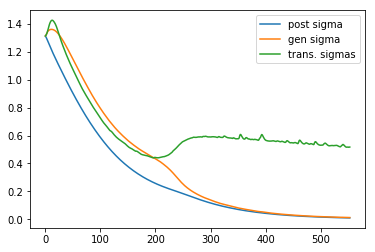

In [360]:
# p is RNN + linear proj., sigma_c is unknown, q is an RNN on the observed values + linear proj. (10 sample)
plt.plot(np.squeeze(np.array(post_stddevs)), label='post sigma')
plt.plot(gen_stddevs, label='gen sigma')
plt.plot([np.mean(s) for s in stds], label='trans. sigmas')
plt.legend();

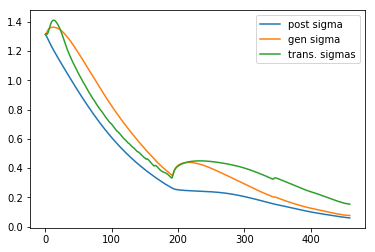

In [350]:
# p is RNN + linear proj., sigma_c is unknown, q is an RNN on the observed values + linear proj. (10 sample)
plt.plot(np.squeeze(np.array(post_stddevs)), label='post sigma')
plt.plot(gen_stddevs, label='gen sigma')
plt.plot([np.mean(s) for s in stds], label='trans. sigmas')
plt.legend();

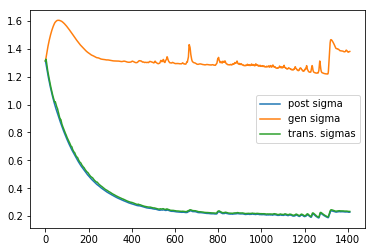

In [335]:
# p is RNN + linear proj., sigma_c is unknown, q is an RNN on the observed values + linear proj. (10 sample)
plt.plot(np.squeeze(np.array(post_stddevs)), label='post sigma')
plt.plot(gen_stddevs, label='gen sigma')
plt.plot([np.mean(s) for s in stds], label='trans. sigmas')
plt.legend();

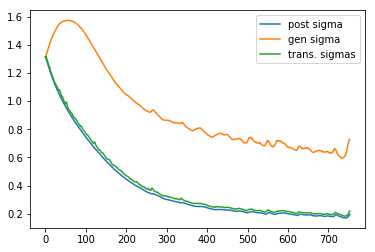

In [330]:
# p is RNN + linear proj., sigma_c is unknown, q is an RNN on the observed values + linear proj. (10 sample)
plt.plot(np.squeeze(np.array(post_stddevs)), label='post sigma')
plt.plot(gen_stddevs, label='gen sigma')
plt.plot([np.mean(s) for s in stds], label='trans. sigmas')
plt.legend();

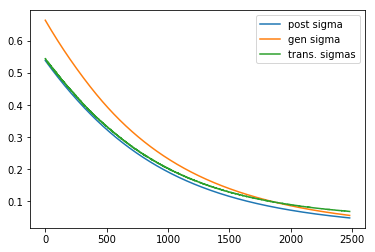

In [43]:
# p is RNN + linear proj., sigma_c is unknown, q is an RNN on the observed values + linear proj. (10 sample)
plt.plot(np.squeeze(np.array(post_stddevs))[1000:], label='post sigma')
plt.plot(gen_stddevs[1000:], label='gen sigma')
plt.plot([np.mean(s) for s in stds][1000:], label='trans. sigmas')
plt.legend();

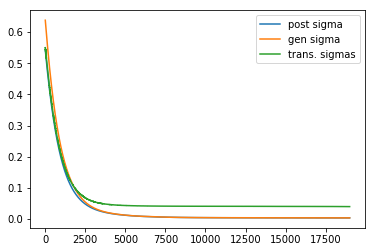

In [9]:
# p is RNN + linear proj., sigma_c is unknown, q is an RNN on the observed values + linear proj. (10 sample)
plt.plot(np.squeeze(np.array(post_stddevs))[1000:], label='post sigma')
plt.plot(gen_stddevs[1000:], label='gen sigma')
plt.plot([np.mean(s) for s in stds][1000:], label='trans. sigmas')
plt.legend();

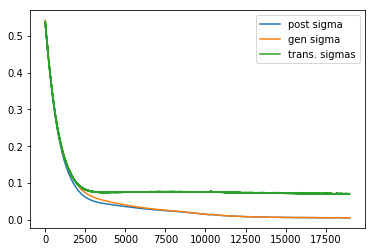

In [296]:
# p is RNN + linear proj., sigma_c is unknown, q is an RNN on the observed values + linear proj. (1 sample)
plt.plot(np.squeeze(np.array(post_stddevs))[1000:], label='post sigma')
plt.plot(gen_stddevs[1000:], label='gen sigma')
plt.plot([np.mean(s) for s in stds][1000:], label='trans. sigmas')
plt.legend();

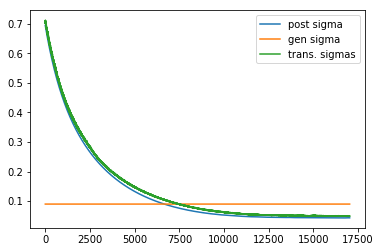

In [292]:
# p is RNN + linear proj., sigma_c is known, q is an RNN on the observed values + linear proj.
plt.plot(np.squeeze(np.array(post_stddevs))[1000:], label='post sigma')
plt.plot(gen_stddevs[1000:], label='gen sigma')
plt.plot([np.mean(s) for s in stds][1000:], label='trans. sigmas')
plt.legend();

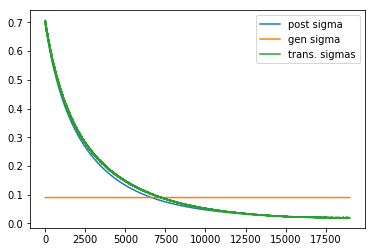

In [277]:
# p is RNN + linear proj., sigma_c is known, q is fully factorised
plt.plot(np.squeeze(np.array(post_stddevs))[1000:], label='post sigma')
plt.plot(gen_stddevs[1000:], label='gen sigma')
plt.plot([np.mean(s) for s in stds][1000:], label='trans. sigmas')
plt.legend();

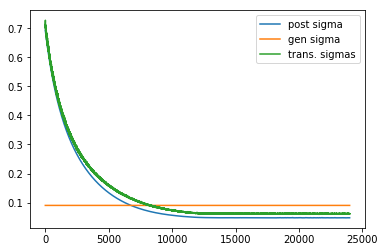

In [267]:
# p is linear, sigma_c is known, q is fully factorised
plt.plot(np.squeeze(np.array(post_stddevs))[1000:], label='post sigma')
plt.plot(gen_stddevs[1000:], label='gen sigma')
plt.plot([np.mean(s) for s in stds][1000:], label='trans. sigmas')
plt.legend();

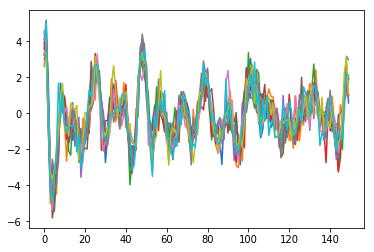

In [381]:
for i in range(10):
    plt.plot(batch[i])

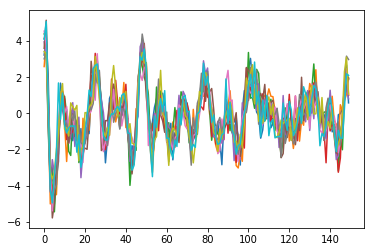

In [380]:
post_means = sess.run(gen_model.make_posterior.mean() , {x_: batch[..., None]})
for i in range(10):
    plt.plot(post_means[i])

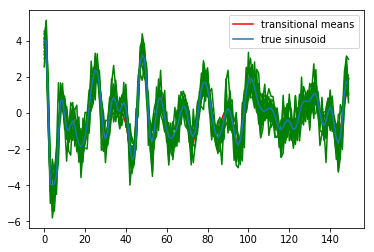

In [377]:
# p is RNN + linear proj., sigma_c is unknown, q is an RNN on the observed values + linear proj. (10 sample)
# plt.plot(y_tilde[0, :seq_length], 'b', label='data')
plt.plot(np.mean(means[-1], 0), 'r-', label='transitional means')
# plt.plot(stds[-1], 'k', label='transitional stddev')
# plt.plot(np.mean(np.reshape(latents, [-1, seq_length]), 0), 'g', label='posterior sample')
post_means = sess.run(gen_model.make_posterior.mean() , {x_: batch[..., None]})
for i in range(batch_size):
    plt.plot(post_means[i], 'g')
plt.plot(y[1:seq_length], label='true sinusoid')
plt.legend();

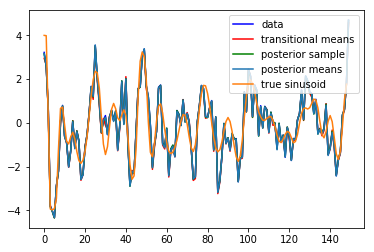

In [351]:
# p is RNN + linear proj., sigma_c is unknown, q is an RNN on the observed values + linear proj. (10 sample)
plt.plot(y_tilde[0, :seq_length], 'b', label='data')
plt.plot(np.mean(means[-1], 0), 'r-', label='transitional means')
# plt.plot(stds[-1], 'k', label='transitional stddev')
plt.plot(np.mean(np.reshape(latents, [-1, seq_length]), 0), 'g', label='posterior sample')
plt.plot(np.mean(sess.run(gen_model.make_posterior.mean() , {x_: batch[..., None]}), 0), label='posterior means')
plt.plot(y[1:seq_length], label='true sinusoid')
plt.legend();

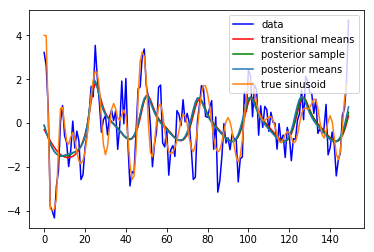

In [341]:
# p is RNN + linear proj., sigma_c is unknown, q is an RNN on the observed values + linear proj. (10 sample)
plt.plot(y_tilde[0, :seq_length], 'b', label='data')
plt.plot(np.mean(means[-1], 0), 'r-', label='transitional means')
# plt.plot(stds[-1], 'k', label='transitional stddev')
plt.plot(np.mean(np.reshape(latents, [-1, seq_length]), 0), 'g', label='posterior sample')
plt.plot(np.mean(sess.run(gen_model.make_posterior.mean() , {x_: batch[..., None]}), 0), label='posterior means')
plt.plot(y[1:seq_length], label='true sinusoid')
plt.legend();

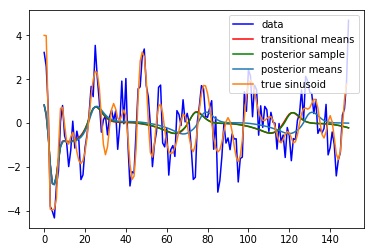

In [339]:
# p is RNN + linear proj., sigma_c is unknown, q is an RNN on the observed values + linear proj. (10 sample)
plt.plot(y_tilde[0, :seq_length], 'b', label='data')
plt.plot(np.mean(means[-1], 0), 'r-', label='transitional means')
# plt.plot(stds[-1], 'k', label='transitional stddev')
plt.plot(np.mean(np.reshape(latents, [-1, seq_length]), 0), 'g', label='posterior sample')
plt.plot(np.mean(sess.run(gen_model.make_posterior.mean() , {x_: batch[..., None]}), 0), label='posterior means')
plt.plot(y[1:seq_length], label='true sinusoid')
plt.legend();

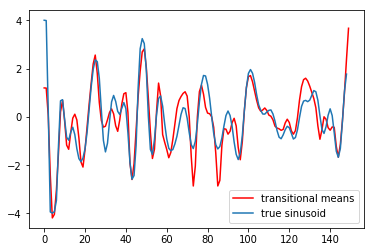

In [332]:
# p is RNN + linear proj., sigma_c is unknown, q is an RNN on the observed values + linear proj. (10 sample)
# plt.plot(y_tilde[0, :seq_length], 'b', label='data')
plt.plot(np.mean(means[-1], 0), 'r-', label='transitional means')
# plt.plot(stds[-1], 'k', label='transitional stddev')
# plt.plot(np.mean(np.reshape(latents, [-1, seq_length]), 0), 'g', label='posterior sample')
# plt.plot(np.mean(sess.run(gen_model.make_posterior.mean() , {x_: batch[..., None]}), 0), label='posterior means')
plt.plot(y[1:seq_length], label='true sinusoid')
plt.legend();

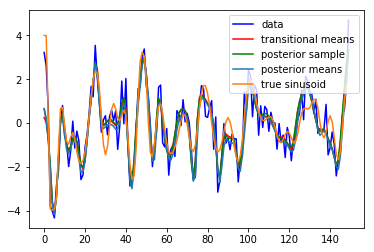

In [327]:
# p is RNN + linear proj., sigma_c is unknown, q is an RNN on the observed values + linear proj. (10 sample)
plt.plot(y_tilde[0, :seq_length], 'b', label='data')
plt.plot(np.mean(means[-1], 0), 'r-', label='transitional means')
# plt.plot(stds[-1], 'k', label='transitional stddev')
plt.plot(np.mean(np.reshape(latents, [-1, seq_length]), 0), 'g', label='posterior sample')
plt.plot(np.mean(sess.run(gen_model.make_posterior.mean() , {x_: batch[..., None]}), 0), label='posterior means')
plt.plot(y[1:seq_length], label='true sinusoid')
plt.legend();

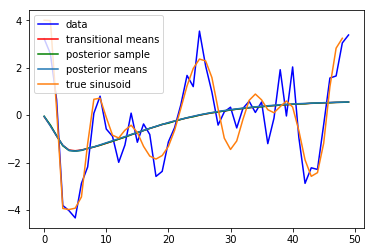

In [314]:
# p is RNN + linear proj., sigma_c is unknown, q is an RNN on the observed values + linear proj. (10 sample)
plt.plot(y_tilde[0, :seq_length], 'b', label='data')
plt.plot(np.mean(means[-1], 0), 'r-', label='transitional means')
# plt.plot(stds[-1], 'k', label='transitional stddev')
plt.plot(np.mean(np.reshape(latents, [-1, seq_length]), 0), 'g', label='posterior sample')
plt.plot(np.mean(sess.run(gen_model.make_posterior.mean() , {x_: batch[..., None]}), 0), label='posterior means')
plt.plot(y[1:seq_length], label='true sinusoid')
plt.legend();

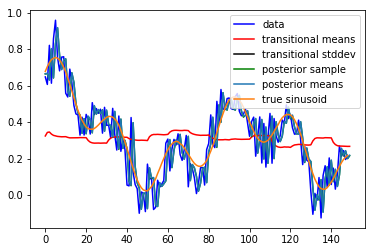

In [59]:
# p is RNN + linear proj., sigma_c is unknown, q is an RNN on the observed values + linear proj. (10 sample)
plt.plot(y_tilde[0, 1:150], 'b', label='data')
plt.plot(np.mean(means[-1], 0), 'r-', label='transitional means')
plt.plot(stds[-1], 'k', label='transitional stddev')
plt.plot(np.mean(np.reshape(latents, [-1, 150]), 0), 'g', label='posterior sample')
plt.plot(np.mean(sess.run(gen_model.make_posterior.mean() , {x_: batch[..., None]}), 0), label='posterior means')
plt.plot(y[1:150], label='true sinusoid')
plt.legend();

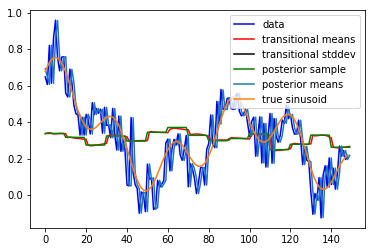

In [33]:
# p is RNN + linear proj., sigma_c is unknown, q is an RNN on the observed values + linear proj. (10 sample)
plt.plot(y_tilde[0, 1:seq_length], 'b', label='data')
plt.plot(np.mean(means[-1], 0), 'r-', label='transitional means')
plt.plot(stds[-1], 'k', label='transitional stddev')
plt.plot(np.mean(latents, 0), 'g', label='posterior sample')
plt.plot(np.mean(sess.run(gen_model.make_posterior.mean() , {x_: batch[..., None]}), 0), label='posterior means')
plt.plot(y[1:seq_length], label='true sinusoid')
plt.legend();

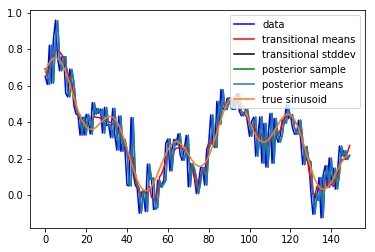

In [297]:
# p is RNN + linear proj., sigma_c is unknown, q is an RNN on the observed values + linear proj. (1 sample)
plt.plot(y_tilde[0, 1:seq_length], 'b', label='data')
plt.plot(np.mean(means[-1], 0), 'r-', label='transitional means')
plt.plot(stds[-1], 'k', label='transitional stddev')
plt.plot(np.mean(np.stack(latents, 0), 0), 'g', label='posterior sample')
plt.plot(np.mean(sess.run(gen_model.make_posterior.mean() , {x_: batch[..., None]}), 0), label='posterior means')
plt.plot(y[1:seq_length], label='true sinusoid')
plt.legend();

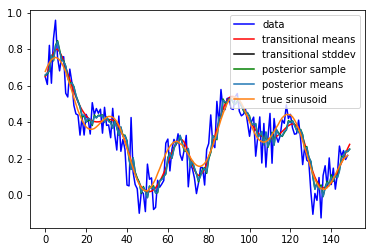

In [293]:
# p is RNN + linear proj., sigma_c is known, q is an RNN on the observed values + linear proj.
plt.plot(y_tilde[0, 1:seq_length], 'b', label='data')
plt.plot(np.mean(means[-1], 0), 'r-', label='transitional means')
plt.plot(stds[-1], 'k', label='transitional stddev')
plt.plot(np.mean(np.stack(latents, 0), 0), 'g', label='posterior sample')
plt.plot(np.mean(sess.run(gen_model.make_posterior.mean() , {x_: batch[..., None]}), 0), label='posterior means')
plt.plot(y[1:seq_length], label='true sinusoid')
plt.legend();

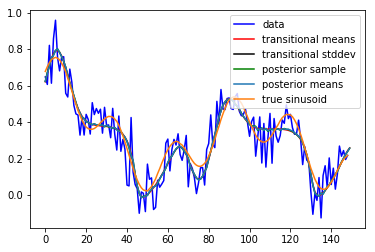

In [279]:
# p is RNN + linear proj., sigma_c is known, q is fully factorised
plt.plot(y_tilde[0, 1:seq_length], 'b', label='data')
plt.plot(np.mean(means[-1], 0), 'r-', label='transitional means')
plt.plot(stds[-1], 'k', label='transitional stddev')
plt.plot(np.mean(np.stack(latents, 0), 0), 'g', label='posterior sample')
plt.plot(np.mean(sess.run(gen_model.make_posterior.mean() , {x_: batch[..., None]}), 0), label='posterior means')
plt.plot(y[1:seq_length], label='true sinusoid')
plt.legend();

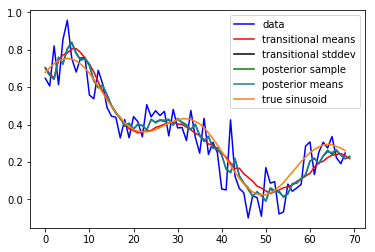

In [272]:
# p is linear, sigma_c is known, q is fully factorised
plt.plot(y_tilde[0, 1:seq_length], 'b', label='data')
plt.plot(np.mean(means[-1], 0), 'r-', label='transitional means')
plt.plot(stds[-1], 'k', label='transitional stddev')
plt.plot(np.mean(np.stack(latents, 0), 0), 'g', label='posterior sample')
plt.plot(np.mean(sess.run(gen_model.make_posterior.mean() , {x_: batch[..., None]}), 0), label='posterior means')
plt.plot(y[1:70], label='true sinusoid')
plt.legend();

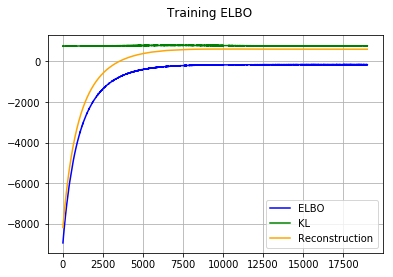

In [282]:
# p is RNN + linear proj., sigma_c is known, q is fully factorised
plt.plot(elbos[1000:], 'b', label='ELBO')
plt.plot(kls[1000:], 'g', label='KL')
plt.plot(llks[1000:], 'orange', label='Reconstruction')
plt.suptitle('Training ELBO')
plt.grid("on")
plt.legend()
plt.show()